https://learn.qiskit.org/v1/course/ch-algorithms/defining-quantum-circuits

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# importing Qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp
from qiskit.circuit import Parameter


In [2]:
# import numpy as np
# import scipy.linalg as la
# des = [7/8, 3/8]
# n = len(des)
# s = np.diag(des)
# q, _ = la.qr(np.random.rand(n, n))
# A = q.T @ s @ q
# eigs_h, vecs_h = np.linalg.eig(A)
# # print(vecs)
# # print(eigs)
# # print('hermitian eigenvalues', eigs_h)
# U = la.expm(1j*A)
# eigs_u, vecs_u = np.linalg.eig(U)
# # print('unitary eigenvalues', eigs_u)
# # print(eigs_u)
# # print(f"{eigs_h[0]} - {eigs_u[0]} = {eigs_h[0] - eigs_u[0]}")
# # print(la.expm(1j*2*np.pi*des[0]))
# print(la.expm(1j*np.pi*des[0]), eigs_u[0])
# # print(vecs_u)
# # print('check:\n', vecs_u[0]*eigs_u[0], '\n', np.dot(U.T, vecs_u[0]))
# # vecs_u[0]*eigs_u[0] == U*vecs_u[0]

In [40]:
from scipy.stats import unitary_group
U = unitary_group.rvs(2)
eigs_u, vecs_u = np.linalg.eig(U)
print(U)
print(eigs_u)

[[-0.16935675-0.81438195j -0.44920424+0.32606116j]
 [-0.31720903-0.45549837j  0.42741222-0.71359544j]]
[-0.4943417 -0.86926767j  0.75239717-0.65870972j]


In [103]:
# need to initialize 2 vectors
U = unitary_group.rvs(2)
eigs_u, vecs_u = np.linalg.eig(U)
print(U)
print(eigs_u)

[[ 0.72028148-0.27336417j -0.42105035+0.47873085j]
 [ 0.52140552-0.36688269j  0.34955821-0.68654383j]]
[0.99929285+0.03760047j 0.07054683-0.99750847j]


In [124]:
U = unitary_group.rvs(2)
eigs_u, vecs_u = np.linalg.eig(U)
print(U)
print(eigs_u)

[[-0.17224381-0.04253193j -0.74664331+0.64112937j]
 [ 0.98249385+0.05682371j -0.11114014+0.13829231j]]
[-0.45822485-0.88883631j  0.1748409 +0.9845967j ]


In [136]:
n_of_qubs = 10
qpe = QuantumCircuit(n_of_qubs+1, n_of_qubs)
qpe.initialize(vecs_u[1], n_of_qubs)
# qpe.draw()

In [137]:
for qubit in range(n_of_qubs):
    qpe.h(qubit)
# qpe.draw()

In [138]:
def get_gate(A, n):    
    pauli_op = PauliSumOp(SparsePauliOp.from_operator(A))
    phi = Parameter('ϕ')
    evolution_op = (phi * pauli_op).exp_i() # exp(-iϕA)
    # print(evolution_op)
    trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evolution_op).bind_parameters({phi: np.pi/n})
    #----control---------
    gate = trotterized_op.to_circuit()
    gate.name = f"e^(i*A*pi/{n})"
    gate.label = f"e^(i*A*np.pi/{n})"
    gate = gate.to_gate().control()
    #---------------------
    return gate

In [139]:
# repetitions = 1
# for counting_qubit in range(3):
#     for i in range(repetitions):
#         qpe.cp(math.pi/4, counting_qubit, 3); # This is CU
#     repetitions *= 2
# qpe.draw()
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
# gate = get_gate(A, 1)
# gate = Operator(U)
from qiskit.circuit.add_control import add_control
gate = UnitaryGate(U).control(1)
repetitions = 1
for i in range(0, n_of_qubs):
    for _ in range(repetitions):
        qpe.append(gate,[i, n_of_qubs])
    repetitions *= 2
# qpe.draw()

In [140]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [141]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, n_of_qubs)
# Measure
qpe.barrier()
for n in range(n_of_qubs):
    qpe.measure(n,n)
# qpe.draw()

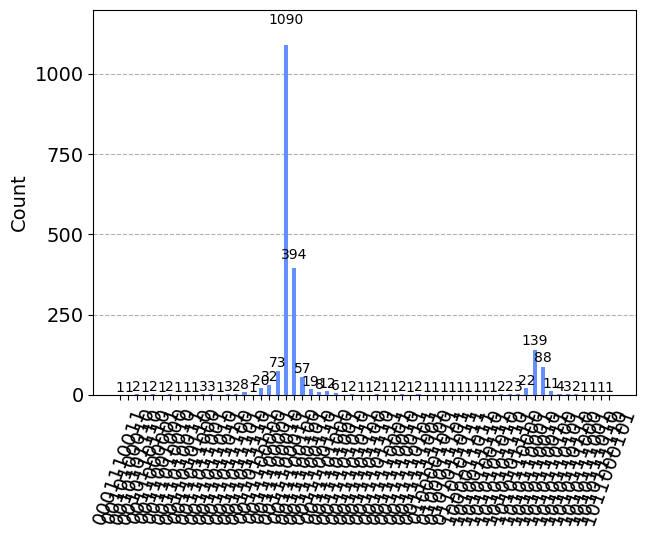

In [142]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer_to_plot = answer.copy()
answer = sorted(answer.items(), key=lambda x:x[1])
new_ans = []
for pair in answer:
    new_ans.append((int(pair[0],2), pair[1]))
answer = new_ans
# print(answer)
plot_histogram(answer_to_plot)
# print(answer)

In [143]:
print(answer)

[(698, 1), (267, 1), (236, 1), (285, 1), (702, 1), (709, 1), (223, 1), (682, 1), (219, 1), (211, 1), (238, 1), (115, 1), (214, 1), (431, 1), (234, 1), (182, 1), (200, 1), (679, 1), (242, 1), (245, 1), (697, 1), (162, 1), (252, 1), (670, 1), (241, 1), (347, 1), (216, 1), (539, 1), (239, 2), (193, 2), (221, 2), (243, 2), (210, 2), (249, 2), (696, 2), (235, 2), (687, 2), (686, 2), (174, 2), (694, 3), (220, 3), (218, 3), (688, 3), (217, 3), (693, 4), (233, 6), (222, 8), (231, 8), (692, 11), (232, 12), (230, 19), (224, 20), (689, 22), (225, 32), (229, 57), (226, 73), (691, 88), (690, 139), (228, 394), (227, 1090)]


In [144]:
import scipy.linalg as la
print(la.expm(1j*2*np.pi*690/1024))
print(la.expm(1j*2*np.pi*227/1024))

[[-0.46053871-0.88763962j]]
[[0.17700422+0.98421009j]]


In [145]:
# print(np.dot(U, vecs_u[1]),  vecs_u[1]*eigs_u[1])

In [146]:
eigs_u

array([-0.45822485-0.88883631j,  0.1748409 +0.9845967j ])